In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
(X_train, _), (X_test, _) =  keras.datasets.fashion_mnist.load_data()
X_train = (X_train)/255
X_test = (X_test)/255

In [3]:
X_train_in = np.asarray([x[:18,:,] for x in X_train])
X_train_out_delay = np.asarray([x[17:-1,:] for x in X_train])
X_train_out = np.asarray([x[18:,:] for x in X_train])

X_test_in = np.asarray([x[:18,:] for x in X_test])
X_test_out_delay = np.asarray([x[17:-1,:] for x in X_test])
X_test_out = np.asarray([x[18:,:] for x in X_test])

In [4]:
# Create Decoder: Takes sequence -> produces state 
encoder_input = keras.layers.Input((None, 28))                                    # (None, Ts, 28)
_, encoder_state = \
    keras.layers.GRU(64, return_state=True, return_sequences=True)(encoder_input) # (None, 64)

encoder = keras.models.Model(encoder_input, encoder_state)


# Create Decoder: Takes sequence and state -> produces sequence and state 
decoder_input = keras.layers.Input((None, 28))                                    # (None, Ts, 28)   
decoder_state_input = keras.layers.Input((64,))                                   # (None,     64)
decoder_gru = keras.layers.GRU(64, return_sequences=True, return_state=True)      # ---
decoder_gru_output, decoder_gru_state = \
    decoder_gru(decoder_input, initial_state=decoder_state_input)                 # (None, Ts, 64), (None, 64)                
decoder_dense = keras.layers.Dense(28, activation="sigmoid")                      # ---
decoder_dense_output = decoder_dense(decoder_gru_output)                          # (None, Ts, 28)

decoder = keras.models.Model([decoder_input, decoder_state_input], [decoder_dense_output, decoder_gru_state])


# Create Encoder-Decoder: Takes encoder input and decoder input -> produces sequence 
decoder_gru_output, _ = decoder_gru(decoder_input, initial_state=encoder_state)   
decoder_dense_output = decoder_dense(decoder_gru_output)                          # (None, Ts, 28) 

enc_dec = keras.models.Model([encoder_input, decoder_input], decoder_dense_output)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
def predict(seq, n_steps = 10):         # (1, Ts, 28) 
    
    output = []
    
    state = encoder.predict(seq)
    decoder_input = seq[:, -1:]
        
    for _ in range(n_steps):
        
        decoder_input, state = decoder.predict([decoder_input, state])
        output.append(decoder_input.ravel())
        
    return np.asarray(output)          # (1, n_steps, 28) 

In [16]:
enc_dec.compile("adam", "binary_crossentropy")

In [22]:
enc_dec.fit([X_train_in, X_train_out_delay], X_train_out, epochs=200, batch_size=256)

Epoch 1/200
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2850
Epoch 2/200
60000/60000 [==============================] - 4s 65us/sample - loss: 0.2839
Epoch 3/200
 4608/60000 [=>............................] - ETA: 3s - loss: 0.2831

KeyboardInterrupt: 

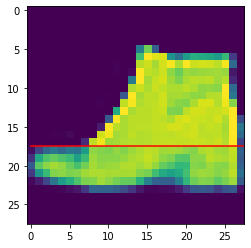

In [32]:
import matplotlib.pyplot as plt
idx = np.random.randint(X_test.shape[0])

pred = predict(X_test_in[idx:idx+1])

plt.imshow(np.concatenate([X_test_in[idx], pred], axis=0)[:,:])
plt.plot([0,27.5],[17.5, 17.5], color="red")

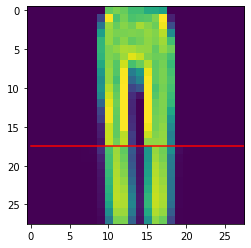

In [62]:
import matplotlib.pyplot as plt
idx = np.random.randint(X_train.shape[0])

pred = model.predict([X_train_in[idx:idx+1], X_train_out_delay[idx:idx+1]])[0]

plt.imshow(np.concatenate([X_train_in[idx], pred], axis=0)[:,:])
plt.plot([0,27.5],[17.5, 17.5], color="red")

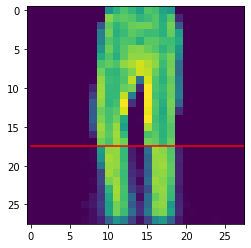

In [76]:
import matplotlib.pyplot as plt
idx = np.random.randint(X_test.shape[0])
plt.imshow(np.concatenate([X_test_in[idx], model.predict(X_test_in[idx:idx+1])[0]], axis=0)[:,:,0])
plt.plot([0,27.5],[17.5, 17.5], color="red")